In [539]:
## A little about the project: I have a dataset of 500 positive and negative reviews for amazon and google, collected from indeed, jobs.ie, etc
## I thought it'll be a fun way to learn and play around with text feature engineering and creating models to predict if a review was positive or negative
## Also, I am gonna try to make some cool visualizations along the way.   

In [589]:
# Importing modules
import warnings

## Data reading and processing
import pandas as pd
import numpy as np

## text processing
import nltk
from nltk.tokenize import word_tokenize
import re

# Data-vis
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import plotly.graph_objects as gp

## machine learning modelling and testing

from sklearn.model_selection import train_test_split


from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score, confusion_matrix

warnings.simplefilter(action='ignore') ## ignoring warning

In [541]:
amazon_reviews = pd.read_csv('amazon_reviews.csv')
google_reviews = pd.read_csv('google_reviews.csv')

In [542]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pg_num  497 non-null    float64
 1   url     497 non-null    object 
 2   pros    496 non-null    object 
 3   cons    497 non-null    object 
dtypes: float64(1), object(3)
memory usage: 15.8+ KB


In [543]:
google_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pg_num  501 non-null    int64 
 1   url     501 non-null    object
 2   pros    501 non-null    object
 3   cons    500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [544]:
amazon_pros = amazon_reviews.dropna().loc[:, 'pros']
amazon_cons = amazon_reviews.dropna().loc[:, 'cons']
google_pros = google_reviews.dropna().loc[:, 'pros']
google_cons = google_reviews.dropna().loc[:, 'cons']

In [545]:
print("Amazon pros: ", amazon_pros.shape)
print("Amazon cons: ", amazon_cons.shape)

print("Google pros: ", google_pros.shape)
print("Google cons: ", google_cons.shape)

Amazon pros:  (496,)
Amazon cons:  (496,)
Google pros:  (500,)
Google cons:  (500,)


In [546]:
def clean_text(df, closed_class_words = [], add = False):

    """
      Function takes in a pandas dataframe with only text column or pandas series of text, a list of closed class words to remove in issolation 
      or addition to the stopwords in nltk which is determined by the add boolean and :
            1) removes letter case
            2) removes punctuations, symbols(&,+,-,@) and extra whitespace(s).
            3) removes numerical data (since we do not need it for our purpose), we could have conveted it to english if it was required
            4) removes english closed class words as defined in the nltk library by default, if no list of closed class words is provided.  
    """

    ## dealing with closed class words or stop words
    
    if(len(closed_class_words) == 0): ## no external list of closed class words provided
        closed_class_words = set(nltk.corpus.stopwords.words('english')) ## 180 stopwords by default
        add = False ## we do not need to add closed class words with nltk default since we do not have extra words
    if (add):
        closed_class_words = set(closed_class_words + nltk.corpus.stopwords.words('english')) 

    
    for review in range(len(df.values)):
        updated_review = df.values[review] ## extracting single review
        for stopword in closed_class_words:
            stopword = ' ' + stopword + ' ' ## we dont want a, an, the, etc to go missing between proper words
            updated_review = updated_review.replace(stopword, ' ') ## replacing 1 stopword at a time with white space
        ## updating the cleaned review after going over all the stop words
        df.values[review] = updated_review
    ## converting all text to lowercase
    df = df.str.lower()
    ## removing all punctuations and symbols 
    df = df.str.replace(r'[^\w]', ' ')
    ## removing all numeric data
    df = df.str.replace(r'[^\D]', ' ')

    


    ## removing all that leads to extra whitespace so 
    ## replace whitespace between terms with a single space
    df = df.str.replace(r'\s+', ' ')
    ## remove leading and trailing whitespace
    df = df.str.replace(r'^\s+|\s+?$', '')
    return df

In [547]:
## cleaning all datasets

additional_words = ['company', 'place', 'amazon', 'google', 'day', 'show','everyone' ] ## for our analysis these very frequent words add no additional value to a review

amazon_pros_clean = clean_text(amazon_pros, closed_class_words= additional_words, add = True)
amazon_cons_clean = clean_text(amazon_cons,closed_class_words= additional_words, add = True)

google_pros_clean = clean_text(google_pros, closed_class_words= additional_words, add = True)
google_cons_clean =  clean_text(google_cons, closed_class_words= additional_words, add = True)

In [548]:
## for refernce let's check randomly how our text has changed
print('Cleaned text: ', amazon_cons_clean[5])
print("Orignal text:" ,amazon_cons[5])

Cleaned text:  long hours two minute breaks half hour lunch to stand concrete without able sit hard good luck trying get days work life start they tell days yo work either except move on do get sick working there people gotten fired fainting work if fast enough make ridiculously high rate the show more
Orignal text: Long hours two 15 minute breaks half hour lunch, to stand concrete without able sit hard. Good luck trying get days work life start. They tell days yo work. Either except move on. Do get sick working there. People gotten fired fainting work. If fast enough make ridiculously high rate, the??Show More


In [549]:
## next step is to normalize our text since we plan to use the n-gram approach to build features and our models later on

## the snowball or porter2 algorithim is an imporved verison of the orignal stemming algorithim and isn't as aggresive as the Lancaster algorithim.

In [550]:
## Using the snowball algorithim from nltk
snowball = nltk.stem.SnowballStemmer(language= 'english')

google_pros_clean_stem =  google_pros_clean.apply(lambda x : ' '.join(snowball.stem(term) for term in x.split()))
google_cons_clean_stem =  google_cons_clean.apply(lambda x : ' '.join(snowball.stem(term) for term in x.split()))

amazon_pros_clean_stem =  amazon_pros_clean.apply(lambda x : ' '.join(snowball.stem(term) for term in x.split()))
amazon_cons_clean_stem =  amazon_cons_clean.apply(lambda x : ' '.join(snowball.stem(term) for term in x.split()))

In [551]:
## comparing the three versions of a random review
print("Orignal text:",amazon_cons[5])
print('Cleaned text: ', amazon_cons_clean[5])
print('stemmed text: ', amazon_cons_clean_stem[5])


Orignal text: Long hours two 15 minute breaks half hour lunch, to stand concrete without able sit hard. Good luck trying get days work life start. They tell days yo work. Either except move on. Do get sick working there. People gotten fired fainting work. If fast enough make ridiculously high rate, the??Show More
Cleaned text:  long hours two minute breaks half hour lunch to stand concrete without able sit hard good luck trying get days work life start they tell days yo work either except move on do get sick working there people gotten fired fainting work if fast enough make ridiculously high rate the show more
stemmed text:  long hour two minut break half hour lunch to stand concret without abl sit hard good luck tri get day work life start they tell day yo work either except move on do get sick work there peopl gotten fire faint work if fast enough make ridicul high rate the show more


In [552]:
## comparing the three versions of a random review
print("Orignal text:",amazon_cons[5])
print('Cleaned text: ', amazon_cons_clean[5])
print('stemmed text: ', amazon_cons_clean_stem[5])

## we see a bit of nonsensical stemmings but that's the price we decided to pay for dimensionality reduction.
## we can and will try modelling without stemming as well, we'll see how that turns out

Orignal text: Long hours two 15 minute breaks half hour lunch, to stand concrete without able sit hard. Good luck trying get days work life start. They tell days yo work. Either except move on. Do get sick working there. People gotten fired fainting work. If fast enough make ridiculously high rate, the??Show More
Cleaned text:  long hours two minute breaks half hour lunch to stand concrete without able sit hard good luck trying get days work life start they tell days yo work either except move on do get sick working there people gotten fired fainting work if fast enough make ridiculously high rate the show more
stemmed text:  long hour two minut break half hour lunch to stand concret without abl sit hard good luck tri get day work life start they tell day yo work either except move on do get sick work there peopl gotten fire faint work if fast enough make ridicul high rate the show more


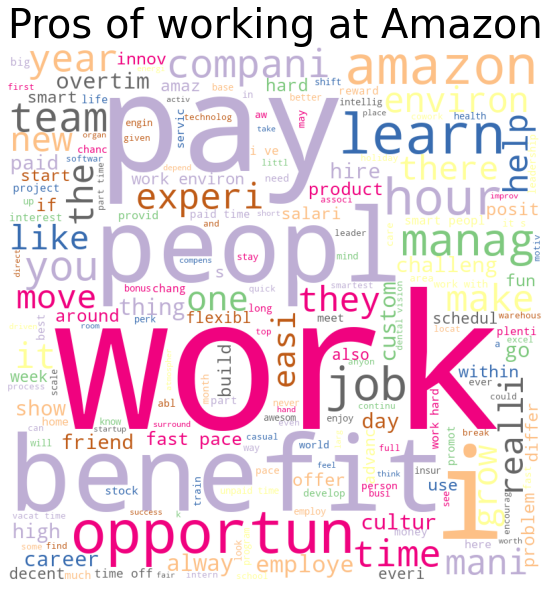

In [553]:
## visualizing wordclouds
## concatinating all the pro reviews
text = ' '
for j in amazon_pros_clean_stem:
    text += ' '.join(token for token in j.split())

wordcloud_ = wordcloud.WordCloud(width = 800, height = 800, stopwords = ['get','lot', 'great', 'good', 'well', 'nice', 'love'],
                background_color ='white',colormap="Accent_r", min_font_size = 10).generate(text)
 
## plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Pros of working at Amazon', fontsize = 40)
plt.imshow(wordcloud_)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

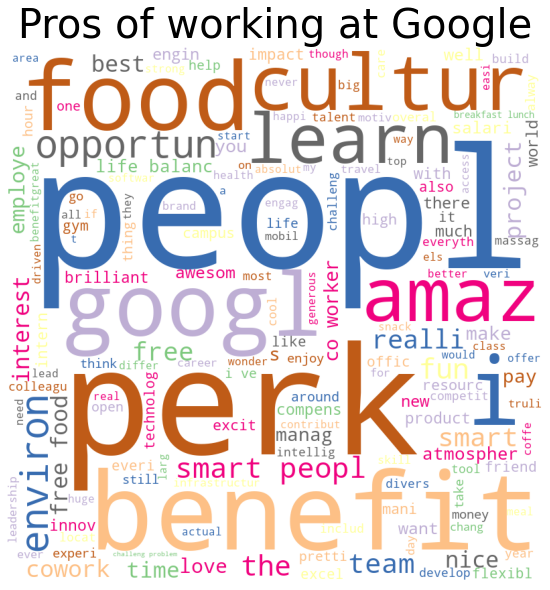

In [554]:
## visualizing wordclouds
## concatinating all the pro reviews
text = ' '
for j in google_pros_clean_stem:
    text += ' '.join(token for token in j.split())
text

wordcloud_ = wordcloud.WordCloud(width = 800, height = 800, stopwords = ['amazon', 'get','lot', 'work', 'job', 'compani',  'place', 'great', 'good'],
                background_color ='white',colormap="Accent_r", min_font_size = 10).generate(text)
 
## plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Pros of working at Google', fontsize = 40)
plt.imshow(wordcloud_)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

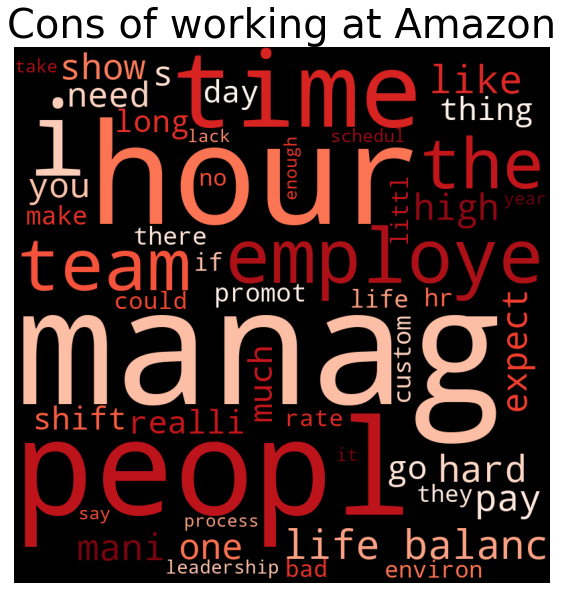

In [555]:
## visualizing wordclouds
## concatinating all the con reviews
text = ' '
for j in amazon_cons_clean_stem:
    text += ' '.join(token for token in j.split())
text

wordcloud_ = wordcloud.WordCloud(width = 800, height = 800,max_words=50, stopwords = ['amazon', 'get','lot', 'work', 'job', 'compani',  'place', 'great', 'good'],
                background_color ='black',colormap="Reds_r", min_font_size = 10).generate(text)
 
## plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Cons of working at Amazon', fontsize = 40)
plt.imshow(wordcloud_)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

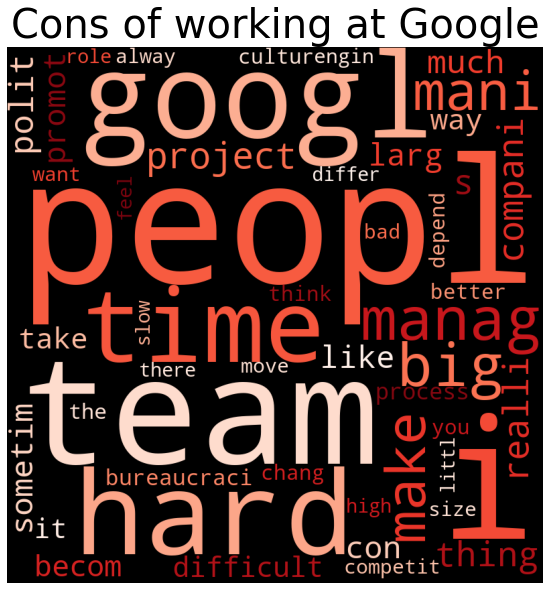

In [556]:
## visualizing wordclouds
## concatinating all the con reviews
text = ' '
for j in google_cons_clean_stem:
    text += ' '.join(token for token in j.split())
text

wordcloud_ = wordcloud.WordCloud(width = 800, height = 800,max_words=50, stopwords = ['get','lot', 'work', 'job', 'place', 'great', 'good'],
                background_color ='black',colormap="Reds_r", min_font_size = 10).generate(text)
 
## plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Cons of working at Google', fontsize = 40)
plt.imshow(wordcloud_)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Pyramid plots

In [595]:
## create frequency dataframes for both con dataframes
all_words = []

for review in amazon_cons_clean_stem:
    words = word_tokenize(review)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

words_list = []
frequency_list = []
for k in all_words.most_common():
    words_list.append(k[0])
    frequency_list.append(k[1])
amazon_cons_word_frequency = pd.DataFrame({'word': words_list, 'frequency' : frequency_list})


all_words = []

for review in google_cons_clean_stem:
    words = word_tokenize(review)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

words_list = []
frequency_list = []
for k in all_words.most_common():
    words_list.append(k[0])
    frequency_list.append(k[1])
google_cons_word_frequency = pd.DataFrame({'word': words_list, 'frequency' : frequency_list})
google_cons_word_frequency.head()

cons_frequency = pd.merge(amazon_cons_word_frequency,google_cons_word_frequency, left_on='word', right_on='word',
                           how = 'inner',suffixes=['_amazon', '_google'])
print(cons_frequency.iloc[:10, ])

## creating a pyramid plot

y_word = cons_frequency.iloc[:15, ]['word']
amazon = cons_frequency.iloc[:15, ]['frequency_amazon']
google = cons_frequency.iloc[:15, ]['frequency_google'] *-1 


## creating the pyramid plot

# Creating instance of the figure
fig = gp.Figure()
  
# Adding Male data to the figure
fig.add_trace(gp.Bar(y= y_word, x = amazon, 
                     name = 'Amazon', 
                     orientation = 'h'))
  
# Adding Female data to the figure
fig.add_trace(gp.Bar(y = y_word, x = google,
                     name = 'Google', orientation = 'h'))
  
# Updating the layout for our graph
fig.update_layout(title = 'Amazon vs google Cons',
                 title_font_size = 32, barmode = 'overlay',
                 bargap = 0.0, bargroupgap = 0, width=1050, height=800)
  
fig.show()


    word  frequency_amazon  frequency_google
0   work               227               142
1  manag               119                57
2   hour                99                24
3      i                85                82
4   time                75                56
5    the                73                51
6  peopl                70                64
7    get                66                87
8   life                57                23
9   long                56                21


In [560]:
## create frequency dataframes for both pros dataframes
all_words = []

for review in amazon_pros_clean_stem:
    words = word_tokenize(review)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

words_list = []
frequency_list = []
for k in all_words.most_common():
    words_list.append(k[0])
    frequency_list.append(k[1])
amazon_pros_word_frequency = pd.DataFrame({'word': words_list, 'frequency' : frequency_list})


all_words = []

for review in google_pros_clean_stem:
    words = word_tokenize(review)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

words_list = []
frequency_list = []
for k in all_words.most_common():
    words_list.append(k[0])
    frequency_list.append(k[1])
google_pros_word_frequency = pd.DataFrame({'word': words_list, 'frequency' : frequency_list})


pros_frequency = pd.merge(amazon_pros_word_frequency,google_pros_word_frequency, left_on='word', right_on='word',
                           how = 'inner',suffixes=['_amazon', '_google'])

## creating a pyramid plot

y_word = pros_frequency.iloc[:15, ]['word']
amazon = pros_frequency.iloc[:15, ]['frequency_amazon']
google = pros_frequency.iloc[:15, ]['frequency_google'] *-1 

## creating the interactive pyramid plot

# Creating instance of the figure
fig = gp.Figure()
  
# Adding Male data to the figure
fig.add_trace(gp.Bar(y= y_word, x = amazon, 
                     name = 'Amazon', 
                     orientation = 'h'))
  
# Adding Female data to the figure
fig.add_trace(gp.Bar(y = y_word, x = google,
                     name = 'Google', orientation = 'h'))
  
# Updating the layout for our graph
fig.update_layout(title = 'Amazon vs google PROS',
                 title_font_size = 32, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0, width=1050, height=800
                 )
  
fig.show()



***What can we observe?***

**What are the perks of working at google?**

➔ Outstanding co-workers, that are smart, friendly, hardworking and talented.

➔ People enjoy the work, a lot of great perks.

➔ Great work environment with opportunities to grow.

➔ Good work life balance


**What are the cons of working at google?**

➔ Bureaucracy

➔ Management

➔ The amount of work is huge, the work is hard and sometimes can be boring.

➔ Long hours



**What are the cons of working at amazon?**

➔ Management seems to be a big issue

➔ Long hours and short breaks

➔ Employees feel burnt out

➔ Poor work life balance


**What are the pros of working at amazon?**

➔ Great Pay

➔ Smart co-workers

➔ High visibility impact work

➔ Great work with opportunities of advancement.



**Which company has a better pay perception?**

Ans: Amazon

**Which company has a better Work life balance?**

Ans: Google

**Which company offers better perks?**

Ans: Unclear, probably Amazon.

**Which company has a better work environment?**
Ans: Google

# Text classification 

Create a labeled dataset for possitive and negative reviews 

Next, engineer features using ba of words and use the feature to build a model to classify review to possitive/negative.  

In [562]:
## creating a clolumn in each dataframe and concating them to create a single data frame.

class_ = [0] * len(amazon_cons_clean_stem) ## setting class = con/negative = 0
amazon_cons_clean_stem_df = pd.DataFrame({'procesed_text': amazon_cons_clean_stem.values, 'label': class_})

class_ = [0] * len(google_cons_clean_stem)
google_cons_clean_stem_df = pd.DataFrame({'procesed_text': google_cons_clean_stem.values, 'label': class_})

class_ = [1] * len(amazon_pros_clean_stem) ## setting class = pos/pro = 1
amazon_pros_clean_stem_df = pd.DataFrame({'procesed_text': amazon_pros_clean_stem.values, 'label': class_})

class_ = [1] * len(google_pros_clean_stem)
google_pros_clean_stem_df = pd.DataFrame({'procesed_text': google_pros_clean_stem.values, 'label': class_})


total_df = pd.concat([google_pros_clean_stem_df, amazon_cons_clean_stem_df , google_cons_clean_stem_df, amazon_pros_clean_stem_df])
total_df = total_df.reset_index().drop(columns=['index'])
total_df.shape

(1992, 2)

In [583]:
## engineering features: unigrams and bigrams

all_words = []

for review in total_df.procesed_text:
    words = word_tokenize(review)
    for w in words:
        all_words.append(w)
        
all_words_unigrams = nltk.FreqDist(all_words)
all_words_bigrams = nltk.FreqDist(nltk.bigrams(all_words))


In [564]:
word_features = [x[0] for x in all_words_unigrams.most_common(900)] ## arbitrary, can we hypertune it?
bigram_features = [x[0] for x in all_words_bigrams.most_common(5)] 

In [585]:
def extract_features(review, use_bigrams = False):
    words = word_tokenize(review)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    ## adding bigrams
    if(use_bigrams):
        for bigram in bigram_features:
            new_feature = bigram[0] + ' ' + bigram[1]
            features[new_feature] = (bigram in bigram_features)
    return features

In [586]:
labeled_reviews = list(zip(total_df.procesed_text, total_df.label))

np.random.seed(2023)
np.random.shuffle(labeled_reviews)

## extract features for each review
feature_set = [(extract_features(text_, False), label) for (text_, label) in labeled_reviews] ## using unigrams only

In [587]:
training, test = train_test_split(feature_set, test_size=0.25, random_state=1)

In [578]:


names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SGD Classifier',
         'Naive Bayes', 'Support Vector Classifier']

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter=100),
    MultinomialNB(),
    SVC(kernel='linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, test)
    print("{} model Accuracy: {}".format(name, accuracy))

K Nearest Neighbors model Accuracy: 0.7449799196787149
Decision Tree model Accuracy: 0.7570281124497992
Random Forest model Accuracy: 0.8413654618473896
Logistic Regression model Accuracy: 0.8534136546184738
SGD Classifier model Accuracy: 0.8152610441767069
Naive Bayes model Accuracy: 0.8795180722891566
Support Vector Classifier model Accuracy: 0.8293172690763052


In [590]:
## using unigrams and bigrams 

In [591]:
labeled_reviews = list(zip(total_df.procesed_text, total_df.label))

np.random.seed(2023)
np.random.shuffle(labeled_reviews)

## extract features for each review
feature_set = [(extract_features(text_, use_bigrams=True), label) for (text_, label) in labeled_reviews] ## using unigramsand biagrams

In [592]:


names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SGD Classifier',
         'Naive Bayes', 'Support Vector Classifier']

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter=100),
    MultinomialNB(),
    SVC(kernel='linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, test)
    print("{} model Accuracy: {}".format(name, accuracy))

K Nearest Neighbors model Accuracy: 0.6967871485943775
Decision Tree model Accuracy: 0.7289156626506024
Random Forest model Accuracy: 0.8032128514056225
Logistic Regression model Accuracy: 0.8232931726907631
SGD Classifier model Accuracy: 0.7710843373493976
Naive Bayes model Accuracy: 0.8353413654618473
Support Vector Classifier model Accuracy: 0.8092369477911646


In [593]:
## the acuracy decrease on including bigrams.
## Therefore we stick to unigrams and we could prune the trees and tune other hyperparameters for better 
## prediction and generalization, but for now naive bayes does the bestjob.